In [48]:
import os, sys, random
import numpy as np
import matplotlib.pyplot as plt
import pylab
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd
import torch.utils.data 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torchviz import make_dot
from scipy.io import savemat
from keras import backend as K

ModuleNotFoundError: No module named 'torch'

In [ ]:
#All from previous CNN functions

def ani_frame(X, N_TIME_STEPS, name, dataset, norm=False, dpi=100):
    # Create a figure with a single subplot
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(X[5,:,:], origin='lower', interpolation='bicubic', cmap='jet')
    fig.colorbar(im)

    test = X[X!=0]
    print('mean/stddev', np.mean(test), np.std(test))
    
    im.set_clim([0, np.amax(X)])

    def update_img(n):
        tmp = X[n,:,:]
        im.set_data(tmp)
        return im

    ani = animation.FuncAnimation(fig, update_img, N_TIME_STEPS, interval=30)
    writer = animation.FFMpegWriter(fps=30)

    ani.save(dataset + 'fno/' + name + '_demo.mp4', writer=writer, dpi=dpi)
    return ani

def getani(X, ns, dataset, which, norm=False):
    ani_frame(X, ns, which, dataset, norm)

    
def loaddata(dataset, var):
    varz = np.load(dataset + var + '.npz')
    var = np.transpose(varz['arr_0'], (2, 0, 1))
    return var

def getdata(dataset):
    variables = ['no', 'T', 'kPlanck','radVar1', 'radVar2', 'Delq']
    data = {}
    for i, var in enumerate(variables):
        data[var] = loaddata(dataset, var)
    return data

def organizedata(dataset,which):
    data = getdata(dataset+which)
    zdata = data

    ns = len(data['no'][:, 0, 0])
    nps = len(data['no'][0, :, 0])

    print("number of time steps, ns: ", ns)
    print("number pixels, nps: ", nps)
    print("max no", np.amax(data['no']))
    print("max T", np.amax(data['T']))
    print("max radVar1", np.amax(data['radVar1']))
    print("max radVar2", np.amax(data['radVar2']))

    # normalized variables
    norm_input_vars = getnorm(data,'inputs')
    norm_target_vars = getnorm(data,'targets')

    # Define a list of normalized input variables
    input_vars = []
    for var in norm_input_vars:
        input_vars.append(norm_input_vars[var])

    # Define a list of normalized target variables
    target_vars = []
    for var in norm_target_vars:
        target_vars.append(norm_target_vars[var])

    # Stack the input and target variables into arrays
    inputs = np.stack(input_vars, axis=1)
    targets = np.stack(target_vars, axis=1)
    return inputs, targets, zdata, norm_input_vars, norm_target_vars

def getnorm(data, which):
    if which == 'targets':
        targets = {}
        for var in ['radVar1', 'radVar2']:
            targets[var] = normalize(data[var], which)
        return targets
    elif which == 'inputs':
        inputs = {}
        for var in ['no', 'T']:
            inputs[var] = normalize(data[var], which)
        return inputs
    else:
        normalized_data = {}
        for var in data:
            normalized_data[var] = normalize(data[var], which)
        return normalized_data


def transform(A, which):
    Amax = np.amax(A)
    Amin = np.amin(A)
    Range = Amax - Amin

    if which == 'ilal':
        # inverse logit after log
        var = A / (1 + A)
    elif which == 'silal':
        # square inverse logit after log
        var = A * A / (1 + A * A)
    elif which == 'exp':
        # exponential
        var = 1 - np.exp(A)
    elif which == 'norm':
        # norm 0 to 1
        var = (A - Amin) / Range

    return var

def detransform(A, zA, which):
    Amax = np.amax(zA)
    Amin = np.amin(zA)
    Range = Amax - Amin
    print('mix/max original', Amin, Amax)
    print('min/max transformed', np.amin(A), np.amax(A))

    if which == 'ilal':
        # inverse logit after log
        var = A * (1 + zA)
    elif which == 'silal':
        # square inverse logit after log
        var = np.sqrt(A * A * (1 + zA * zA))
    elif which == 'exp':
        # exponential
        var = A + np.exp(zA) - 1
    elif which == 'norm':
        # norm 0 to 1
        var = A * Range + Amin
    print('min/max detransformed',np.amin(var),np.amax(var))
    return var 

def normalize(A,which):
    if which == 'targets':
        Anrm = transform(A,'ilal')
    else:
        Anrm = transform(A,'norm')
    return Anrm

def denormalize(A, zA, which):
    if which == 'targets':
        Adnrm = detransform(A, zA, 'ilal')
    else:
        Adnrm = detransform(A, zA, 'norm')
    return Adnrm

def getdenorm(zdata, data, which):
    if which == 'targets':
        denorm_data = {}
        for var in ['radVar1', 'radVar2']:
            denorm_data[var] = denormalize(zdata[var], data[var], which)
        return denorm_data
    elif which == 'inputs':
        denorm_data = {}
        for var in ['no', 'T']:
            denorm_data[var] = denormalize(zdata[var], data[var], which)
        return denorm_data
    else:
        denorm_data = {}
        for var in zdata:
            denorm_data[var] = denormalize(zdata[var], data[var], which)
        return denorm_data



def showSbs(inputs, targets, i):
    f, ax = plt.subplots(2, 2)
    f.tight_layout()
    [axi.set_axis_off() for axi in ax.ravel()]
    
    data = [(inputs[i, 0, :, :], 'Input 1'), (inputs[i, 1, :, :], 'Input 2'),
            (targets[i, 0, :, :], 'Target 1'), (targets[i, 1, :, :], 'Target 2')]
    
    for axi, (data, label) in zip(ax.ravel(), data):
        im = axi.imshow(data, origin='lower', cmap='jet')
        im.set_clim([0, np.amax(data)])
        axi.set_title(label)
    
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
    f.colorbar(im, cax=cbar_ax)

In [ ]:
import torch.nn.functional as F
from timeit import default_timer
#from utilities3 import *
#from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
ntrain = 200
ntest = 100

batch_size = 20
learning_rate = 0.001

epochs = 1
step_size = 10
gamma = 0.5

modes = 12
width = 32

r1 = 1
r2 = 1
s1 = 128#int(((221 - 1) / r1) + 1)
s2 = 128#int(((51 - 1) / r2) + 1)

dataset = 'd300s200/'
inputs, targets, zdata, norm_input_vars, norm_target_vars = organizedata(dataset,'train/')
ns = len(zdata['no'][:, 0, 0])
nps = len(zdata['no'][0, :, 0])

#output = torch.tensor(targets, dtype=torch.float)
# Split the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.20, random_state=42, shuffle=True)

x_train = inputs[:ntrain, ::r1, ::r2]
y_train = targets[:ntrain, ::r1, ::r2]
x_test = inputs[ntrain:ntrain+ntest, ::r1, ::r2]
y_test = targets[ntrain:ntrain+ntest, ::r1, ::r2]
x_train = x_train.reshape(ntrain, s1, s2, 2)
x_test = x_test.reshape(ntest, s1, s2, 2)
y_train = y_train.reshape(ntrain, s1, s2, 2)
y_test = y_test.reshape(ntest, s1, s2, 2)

print("Size of the inputs array: "+format(x_train.shape))
print("Size of the targets array: "+format(y_test.shape))
print("Size of the vinputs array: "+format(x_test.shape))
print("Size of the targets array: "+format(y_train.shape))

class DfpDataset():
    def __init__(self, inputs,targets): 
        self.inputs  = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

tdata = DfpDataset(x_train,y_train)
vdata = DfpDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(tdata, batch_size=batch_size,
                                           shuffle=True, drop_last = True)
test_loader = torch.utils.data.DataLoader(vdata, batch_size=batch_size,
                                          shuffle=False, drop_last = True)
test_loader2 = torch.utils.data.DataLoader(vdata, batch_size=1,
                                          shuffle=False, drop_last = True)

# train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size,
#                                            shuffle=True)
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size,
#                                           shuffle=False)
# test_loader2 = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1,
#                                           shuffle=False)

#showSbs(x_train,y_train,3)

number of time steps, ns:  300
number pixels, nps:  128
max no 0.34538015723228455
max T 4099.181640625
max radVar1 42618.44138049999
max radVar2 215035.618752
Size of the inputs array: (200, 128, 128, 2)
Size of the targets array: (100, 128, 128, 2)
Size of the vinputs array: (100, 128, 128, 2)
Size of the targets array: (200, 128, 128, 2)


In [ ]:
################################################################
# fourier layer (ignore really)
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat,
                             device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 8  # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(4, self.width)  # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x = F.pad(x, [0, self.padding, 0, self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20, 128, 128, 2])) that is different to the input size (torch.Size([20, 128, 128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 63.382899348000024 6582.6698046875 tensor(13313.3223)
(128, 128)
(128, 128, 2)


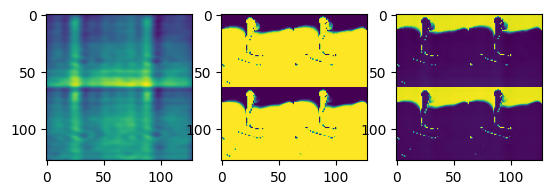

In [ ]:
################################################################
# training and evaluation
################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = FNO2d(modes*2, modes, width).to(device)
#print(K.count_params(model))

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

#No LpLoss found? Subbed for L2 Loss
myloss = nn.MSELoss(size_average=False)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        x = x.to(torch.float)
        y = y.to(torch.float)

        out = model(x)

        #.view(batch_size, -1)
        loss = myloss(out, y)
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            x = x.to(torch.float)
            y = y.to(torch.float)

            out = model(x)
            test_l2 += myloss(out, y)

    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2 - t1, train_l2, test_l2)

    # plot
    if ep%step_size==0:

        ind = -1
        # X = x[ind, :, :, 0].squeeze().detach().cpu().numpy()
        # Y = x[ind, :, :, 1].squeeze().detach().cpu().numpy()
        truth = y[ind].squeeze().detach().cpu().numpy()
        pred = out[ind].squeeze().detach().cpu().numpy()
        nx = 40//r1
        ny = 20//r2
        print(pred.shape)
        print(truth.shape)
        # X_small = X[nx:-nx, :ny]
        # Y_small = Y[nx:-nx, :ny]
        truth_small = truth[nx:-nx, :ny]
        pred_small = pred[nx:-nx, :ny]

        fig,axs = plt.subplots(1, 3)
        axs[0].imshow(pred)
        axs[1].imshow(truth[:,:,1]) #radVar1
        axs[2].imshow(pred - truth[:,:,1])
        plt.show()

torch.save(model, 'fno_model')

In [ ]:
testinputs, testtargets, zdatand, norm_input_vars_nd, norm_target_vars_nd = organizedata(dataset,'test/')

x_train = testinputs[:ntrain, ::r1, ::r2]
y_train = testtargets[:ntrain, ::r1, ::r2]
x_test = testinputs[ntrain:ntrain+ntest, ::r1, ::r2]
y_test = testtargets[ntrain:ntrain+ntest, ::r1, ::r2]
x_train = x_train.reshape(ntrain, s1, s2, 2)
x_test = x_test.reshape(ntest, s1, s2, 2)
y_train = y_train.reshape(ntrain, s1, s2, 2)
y_test = y_test.reshape(ntest, s1, s2, 2)

testdata = DfpDataset(x_test,y_test)
testLoader  = torch.utils.data.DataLoader(testdata, batch_size=1, shuffle=False, drop_last=True) 

test_results = {"radVar1": np.zeros((ns,nps,nps)),"radVar2": np.zeros((ns,nps,nps))}

model.eval()
L2t_accum = 0.

for i, validata in enumerate(testLoader, 0):
    # inputs.data.copy_(inputs_curr.float())
    # targets.data.copy_(targets_curr.float())
    x, y = validata
    x, y = x.to(device), y.to(device)
    x = x.to(torch.float)
    y = y.to(torch.float)

    out = model(x)
    outputs_curr = out.data.cpu().numpy()
    o = outputs_curr[0]
    test_results["radVar1"][i,:,:] = o[0,:,:]
    test_results["radVar2"][i,:,:] = o[1,:,:]
    test_l2 += myloss(out, y)
    L2t_accum += test_l2.item()

print("\nAverage test error: {}".format( L2t_accum/len(testLoader) ))

number of time steps, ns:  300
number pixels, nps:  128
max no 0.26989731192588806
max T 3268.87060546875
max radVar1 2376.98621242
max radVar2 260162.20421799997


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 128, 128, 2])) that is different to the input size (torch.Size([1, 128, 128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Average test error: 422778.8119726562


In [ ]:
denorm_input_vars = getdenorm(zdata,norm_input_vars,'inputs')
denorm_target_vars = getdenorm(zdata,norm_target_vars,'targets')
denorm_input_vars_nd = getdenorm(zdatand,norm_input_vars_nd,'inputs')
denorm_target_vars_nd = getdenorm(zdatand,norm_target_vars_nd,'targets')
savemat("denorm_input_vars.mat", denorm_input_vars)
savemat("denorm_target_vars.mat", denorm_target_vars)

mix/max original 0.0 1.0
min/max transformed 0.0 0.34538015723228455


min/max detransformed 0.0 0.34538015723228455
mix/max original 0.0 1.0
min/max transformed 300.0 4099.181640625
min/max detransformed 300.0 4099.181640625
mix/max original 0.0 0.9999765365296304
min/max transformed 0.0 42618.44138049999
min/max detransformed 0.0 85235.88278446345
mix/max original 4.084943671322839e-07 0.9999953496292594
min/max transformed 4.08494534e-07 215035.618752
min/max detransformed 4.084947008677162e-07 430070.2375086504
mix/max original 0.0 1.0
min/max transformed 0.0 0.26989731192588806
min/max detransformed 0.0 0.26989731192588806
mix/max original 0.0 1.0
min/max transformed 300.0 3268.87060546875
min/max detransformed 300.0 3268.87060546875
mix/max original 0.0 0.99957947611522
min/max transformed 0.0 2376.98621242
min/max detransformed 0.0 4752.9728453638845
mix/max original 4.084943671322839e-07 0.9999961562589029
min/max transformed 4.08494534e-07 260162.20421799997
min/max detransformed 4.084947008677162e-07 520323.4084398437


mean/stddev 352.02541045053874 730.8348927292811


KeyboardInterrupt: 

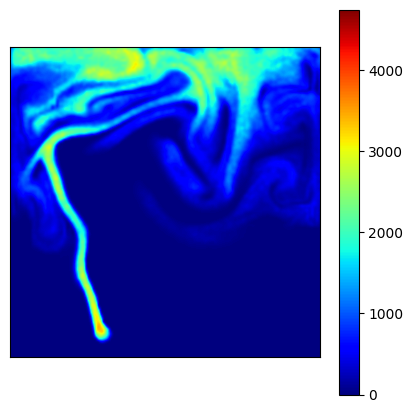

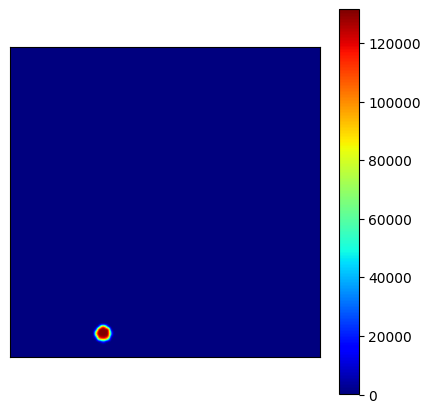

In [ ]:
getani(denorm_target_vars_nd['radVar1'], ns, dataset,'radVar1_data',norm=False)
getani(denorm_target_vars_nd['radVar2'], ns, dataset,'radVar2_data',norm=False)

In [ ]:
denorm_test_vars_nd = getdenorm(zdatand,test_results,'targets')
savemat("denorm_test_vars.mat", denorm_test_vars_nd)

mix/max original 0.0 0.23862484097480774
min/max transformed 0.0 2376.98621242


min/max detransformed 0.0 2907.9518964556505
mix/max original 0.0 0.24247324466705322
min/max transformed 4.08494534e-07 260162.20421799997
min/max detransformed 4.08494534e-07 321798.9049980927


mean/stddev 179.95640493447854 378.3666211508679


mean/stddev 3272.612293876373 14013.936124834801


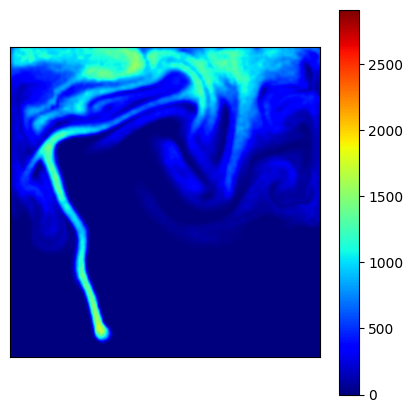

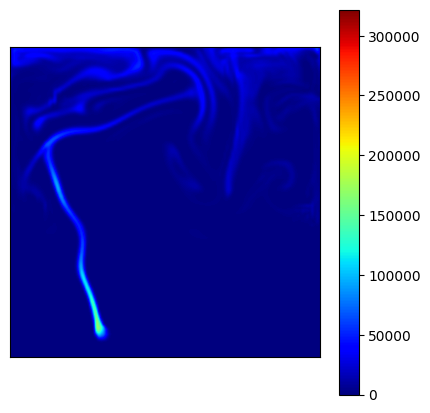

In [ ]:
#Neural network solution

getani(denorm_test_vars_nd['radVar1'], ns, dataset,'radVar1_sol',norm=False)
getani(denorm_test_vars_nd['radVar2'], ns, dataset,'radVar2_sol',norm=False)

mean/stddev 172.06904613884845 355.11123166580654
mean/stddev 3063.2702990725247 12542.604639844863


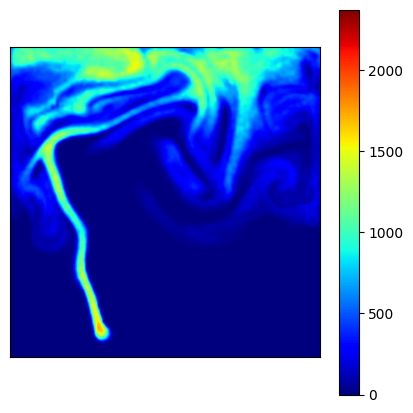

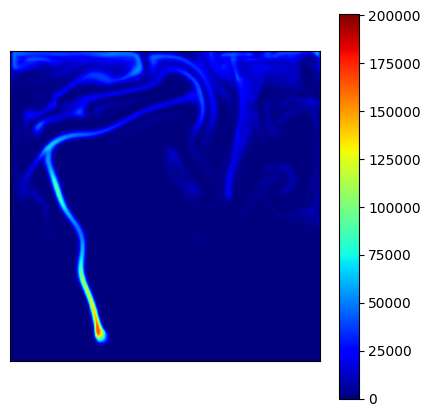

In [ ]:
rv1ae = np.zeros((ns,nps,nps))
rv2ae = np.zeros((ns,nps,nps))
error_dict = {'radVar1': rv1ae, 'radVar2': rv2ae}

for i in range(ns):
    rv1ae[i,:,:] = np.abs(denorm_target_vars_nd['radVar1'][i,:,:] - denorm_test_vars_nd['radVar1'][i,:,:])
    rv2ae[i,:,:] = np.abs(denorm_target_vars_nd['radVar2'][i,:,:] - denorm_test_vars_nd['radVar2'][i,:,:])
savemat("rv1ae.mat", {"error" : error_dict['radVar1']})
savemat("rv2ae.mat", {"error" : error_dict['radVar2']})

getani(error_dict['radVar1'], ns, dataset,'radVar1error',norm=False)
getani(error_dict['radVar2'], ns, dataset,'radVar2error',norm=False)